In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import math

def sin(x):
    return np.sin(np.deg2rad(x))

def cos(x):
    return np.cos(np.deg2rad(x))

def tan(x):
    return np.tan(np.deg2rad(x))

def atan(x):
    return np.arctan(np.deg2rad(x))

### RAW PARAMETERS

In [2]:
dt = 0.001
B = 6.5*10**-3   # temperature lapse rate in troposphere in K/m
R = 287   # ideal gas constant in J/(kg.K)
g = 9.80665  # gravity at sea level in m/s2
T0 = 288.15   # standard air temperature in K
P0 = 101.325   # standard air pressure in kPa
pi = math.pi

### VARIABLES

In [3]:
# Manually Determined
# ... these need to be algorithmically determined eventually
imu_end_time = 19   # visually determined
a0 = 1   # visually determined
w0 = -8.2  # visually determined

In [4]:
# RAW PARAMETERS
dt = 0.001 
a_1 = -2.5 # first acceleration point after dorgue (visually determined)
t_1 = 18.6 # time corresponding to a_1
a_2 = -1   # first acceleration point after dorgue (visually determined)
t_2 = 20.6 # time corresponding to a_2

### imu_process.m

In [5]:
datafile = r'../Data/Trunc_Fullscale1.csv'  # This needs to be updated to whatever the real-time file is
########################################################################

fields = ['Timestamp', 'Pres',
  'Roll', 'Pitch', 'Yaw',
  'LinearAccelNed X', 'LinearAccelNed Y', 'LinearAccelNed Z',
  ]

df = pd.read_csv(datafile, skipinitialspace=True, usecols=fields)
df = df.iloc[30:, :]

In [6]:
imu_t = df['Timestamp'].values
imu_t = imu_t - imu_t[0]
imu_N = len(imu_t)
imu_ax = df['LinearAccelNed X'].values
imu_ay = df['LinearAccelNed Y'].values
imu_az = df['LinearAccelNed Z'].values * -1
imu_pres = df['Pres']

# imu_t[:5]

In [7]:
def nasa_pres(P, P0, T0, R, B, g):
    imu_temp = T0*(P/P0)**(R*B/g)
    imu_alt = (T0 - imu_temp)/B
    return imu_alt

vec_NASA_pres = np.vectorize(nasa_pres)
imu_alt = vec_NASA_pres(imu_pres, P0, T0, R, B, g)   # * ft + 600
imu_alt = imu_alt - imu_alt[imu_N-1]

imu_alt = [val if val > 0 else 0 for val in imu_alt]

In [8]:
################## INIT VECTORS  ##################
imu_vx, imu_vy, imu_vz, imu_x, imu_y, imu_z = (np.zeros((imu_N)), np.zeros((imu_N)), 
                                               np.zeros((imu_N)), np.zeros((imu_N)), 
                                               np.zeros((imu_N)), np.zeros((imu_N)))

################## Find velocity and position  ##################
for i in range(imu_N-1):
    imu_vz[i+1] = imu_vz[i] + imu_az[i]*(imu_t[i+1] - imu_t[i])
    imu_z[i+1] = imu_z[i] + imu_vz[i]*(imu_t[i+1] - imu_t[i])
    
    imu_vx[i+1] = imu_vx[i] + imu_ax[i]*(imu_t[i+1] - imu_t[i])
    imu_x[i+1] = imu_x[i] + imu_vx[i]*(imu_t[i+1] - imu_t[i])
    
    imu_vy[i+1] = imu_vy[i] + imu_ay[i]*(imu_t[i+1] - imu_t[i])
    imu_y[i+1] = imu_y[i] + imu_vy[i]*(imu_t[i+1] - imu_t[i])

### Wind Density Profile

In [9]:
## DERIVED PARAMETERS
delta_t = t_2 - t_1 
w_0 = a_1*delta_t/(sqrt(a_1/a_2)-1); # wind speed at apogee in m/s
K = a_1/w_0**2 
w_0_mph = w_0/0.44704
z_0 = max(imu_alt) # apogee altitude in m

################## CONSTANT WIND PROFILE & AIR DENSITY  ##################
wind_profile_x = np.zeros((imu_N))
density_profile = np.zeros((imu_N))

z0 = max(imu_alt) # apogee altitude in m

w0_mph = w0/0.44704

for i in range(imu_N):
    T = T0 - B * imu_alt[i]
    P = P0 * 1000 * (T/T0)**(g/(R*B))
    density_profile[i] = P/(R*T)
    if imu_alt[i] < 2:
        wind_profile_x[i] = w0*((2/z0)**(1/7))
    else:
        wind_profile_x[i] = w0*((imu_alt[i]/z0)**(1/7))

### Model 1 after drogue

In [10]:
## RAW PARAMETERS
imu_end_time = t_1 # uncertainty start time in s (visually determined)

## MODEL  #1: SIMULATE TRAJECTORY AFTER DROGUE
# Initial parameters
min111 = np.amin(abs(imu_t - imu_end_time))
imu_end_ii = np.where(abs(imu_t - imu_end_time) == min111)[0][0]
sim_start_t = imu_end_time
sim_end_t = imu_t[-1]

# Construct arrays
sim_t = list(np.arange(sim_start_t, sim_end_t, dt))
sim_N = len(sim_t)

sim_ax = np.zeros(sim_N)
sim_vx = np.zeros(sim_N)
sim_x = np.zeros(sim_N)

# Initialize acceleration, velocity, and displacement
sim_ax[0] = imu_vx[imu_end_ii]

sim_ax[0] = a_1

sim_x[0] = imu_x[imu_end_ii]
dV = sim_ax[0] * dt

sim_curr_alt = np.zeros((sim_N))
sim_curr_alt[0] = imu_alt[imu_end_ii]


for i in range(sim_N-1):
    sim_curr_time = sim_t[i+1]    
    min222 = min(abs(imu_t - sim_curr_time))
    imu_index = np.where(abs(imu_t - sim_curr_time) == min222)[0][0]
    
    sim_curr_alt[i+1] = imu_alt[imu_index]
    
    sim_x[i+1] = sim_x[i] + sim_vx[i]*dt + 0.5*dV*dt
    sim_vx[i+1] = sim_vx[i] + dV
    
    sign_bool = (wind_profile_x[imu_index] < 0 and sim_vx[i+1] < 0) or \
                (wind_profile_x[imu_index] > 0 and sim_vx[i+1] > 0) or \
                (wind_profile_x[imu_index] == 0 and sim_vx[i+1] == 0)
    if (abs(wind_profile_x[imu_index]) < abs(sim_vx[i+1])) and sign_bool:
        sim_ax[i+1] = -K * ((wind_profile_x[imu_index] - sim_vx[i+1])**2)
    else:
        sim_ax[i+1] = K * ((wind_profile_x[imu_index] - sim_vx[i+1])**2)
        
    dV = sim_ax[i+1]*dt

# Combine IMU ascent with the simulation
t1 = np.hstack((imu_t[0:imu_end_ii], sim_t))
ax1 = np.hstack((imu_ax[0:imu_end_ii], sim_ax))
vx1 = np.hstack((imu_vx[0:imu_end_ii], sim_vx))
x1 = np.hstack((imu_x[0:imu_end_ii], sim_x))

### Model 2 after takeoff

In [11]:
## MODEL  #2: SIMULATE TRAJECTORY AFTER TAKE OFF
max_sim_time = imu_t[-1] # maximum simulation time in s
# t = list(range(0, max_sim_time, dt))  # time array
t = np.arange(0, max_sim_time, dt)
N = len(t)  # time array size
x, z = np.zeros(N), np.zeros(N)  # z and x displacement array
vx, vz = np.zeros(N), np.zeros(N)  # z and x velocity array
ax, az = np.zeros(N), np.zeros(N)  # z and x acceleration array
v = np.zeros(N)
m = np.zeros(N)  # mass array
theta = np.zeros(N)  # angle array
omega = np.zeros(N)  # angle array
alpha = np.zeros(N)  # angle array
theta0 = 2*pi/180  # launch angle array in radians

In [12]:
# RAW PARAMETERS
m_dry = 16.57  # rocket dry mass in kg
Cd = 0.39  # rocket drag coefficient
Cd_side = 1  # rocket side drag coefficient
L = 2.06  # rocket length in m
D = 0.1524  # rocket diameter in m
SSM = 2.6  # static stability margin
T_avg = 1740  # average motor thrust in N
t_burn = 2.1  # motor burn time in s
m_motor = 1.76  # motor wet mass in kg
L_rail = 2  # launch rail transit in m
number_of_time_steps = 2

In [13]:
# DERIVED PARAMETERS
A_rocket = pi*(D**2)/4  # rocket cross sectional area in m2
A_side_r = 0.374  # rocket side area in m2
m_wet = m_dry + m_motor  # rocket wet mass in kg
m_dot = m_motor/t_burn  # motor burn rate in kg/s

# SIMULATION PARAMETERS
i = 1  # loop index
m[i] = m_wet  # initial wet mass in kg
ax[i] = T_avg / m[i] * sin(theta0)
az[i] = T_avg / m[i] * cos(theta0) - g
theta[i] = theta0  # initial angle (launch) in radians
i = i + 1  # increase loop

#### STAGE 1: POWERED ASCENT ON LAUNCH RAIL

In [14]:
# while z altitude is lower than the launch rail altitude
while (np.linalg.norm([x[i-1], z[i-1]]) < L_rail):
    theta[i] = theta0  # constant angle until launch rail is cleared

    x[i] = x[i-1] + vx[i-1]*dt  # calculate x position
    z[i] = z[i-1] + vz[i-1]*dt  # calculate z position

    vz[i] = vz[i-1] + az[i-1]*dt  # calculate z velocity
    vx[i] = vx[i-1] + ax[i-1]*dt  # calculate x velocity
    v[i] = np.linalg.norm([vx[i], vz[i]])  # calculate velocity along axis

    m[i] = m[i-1] - m_dot*dt  # calculate mass

    ax[i] = T_avg/m[i]*sin(theta0)
    az[i] = T_avg/m[i]*cos(theta0) - g

    i = i + 1  # increase simulation step

t_LRE = t[i-1]  # launch rail exit time
i_LRE = i-1

#### STAGE 2: WIND COCKING DURING POWERED ASCENT

In [15]:
# [minDistance, imu_LRE] = min(abs(imu_alt - z(i_LRE)))
# w_LRE = abs(wind_profile_x(imu_LRE))
# tau = (w_LRE/(T_avg/m(i_LRE)-g))*(SSM**2/(SSM-1))

minDistance = np.amin(abs(imu_alt - z[i_LRE]))
imu_LRE = np.where(abs(imu_alt - z[i_LRE]) == minDistance)[0][0]
w_LRE = abs(wind_profile_x[imu_LRE])
tau = (w_LRE/(T_avg/m[i_LRE]-g))*(SSM**2/(SSM-1))

# min111 = np.amin(abs(imu_t - imu_end_time))
# imu_end_ii = np.where(abs(imu_t - imu_end_time) == min111)[0][0]

# whole wind cocking occurs
while (t[i-1] < t[i_LRE] + number_of_time_steps*tau):
    theta[i] = theta[i-1] + omega[i-1]*dt  # calculate angle
    omega[i] = omega[i-1] + alpha[i-1]*dt  # calculate angular velocity

    x[i] = x[i-1] + vx[i-1]*dt  # calculate x position
    z[i] = z[i-1] + vz[i-1]*dt  # calculate z position

    vz[i] = vz[i-1] + az[i-1]*dt  # calculate z velocity
    vx[i] = vx[i-1] + ax[i-1]*dt  # calculate x velocity
    v[i] = np.linalg.norm([vx[i], vz[i]])  # calculate velocity along axis

    minDistance = np.amin(abs(imu_alt - z[i]))
    imu_index = np.where(abs(imu_alt - z[i]) == minDistance)[0][0]
#     imu_index = imu_alt.index(minDistance + z[i])
    w = abs(wind_profile_x[imu_index])  # side wind calculation
    rho = density_profile[imu_index]

    m[i] = m[i-1] - m_dot*dt  # calculate mass

    I = 1/12*m[i]*(L**2)  # calculate inertia

    FD_side = 0.5*Cd_side*A_side_r*rho*((vx[i]+w)**2)  # calculate side drag
    FD = 0.5*Cd*rho*(v[i]**2)*A_rocket  # calculate drag along axis

    alpha[i] = FD_side*D*cos(theta[i])*SSM/I  # calculate angular accel.

    # calculate acceleration along rocket axis
    dv = (((T_avg-FD-FD_side*sin(theta[i]))/m[i])-g*cos(theta[i]))*dt
    v[i] = v[i-1] + dv

    vx[i] = v[i] * sin(theta[i])
    vz[i] = v[i] * cos(theta[i])

    # accelerations
    ax[i] = (dv/dt) * sin(theta[i])
    az[i] = (dv/dt) * cos(theta[i])
#     alpha[i] = FD_side * SSM * D * cos(theta[i])/I

    i = i + 1  # increase simulation step

#### STAGE 3: POWERED ASCENT

In [16]:
# while MECO is reached
while (t[i-1] < t_burn):
    x[i] = x[i-1] + vx[i-1]*dt  # calculate x position
    z[i] = z[i-1] + vz[i-1]*dt  # calculate z position

#     [minDistance, imu_index] = min(abs(imu_alt - z[i]))
    minDistance = np.amin(abs(imu_alt - z[i]))
    imu_index = np.where(abs(imu_alt - z[i]) == minDistance)[0][0]
    rho = density_profile[imu_index]

    vz[i] = vz[i-1] + az[i-1]*dt  # calculate z velocity
    vx[i] = vx[i-1] + ax[i-1]*dt  # calculate x velocity
    v = sqrt((vz[i])**2 + (vx[i])**2)  # calculate velocity along axis

    theta[i] = atan(vx[i]/vz[i])  # calculate angle

    FD = 0.5*Cd*rho*(v**2)*A_rocket  # calculate drag along axis

    m[i] = m[i-1] - m_dot*dt  # calculate mass

    ax[i] = (T_avg-FD)*sin(theta[i])/m[i]  # calculate x accel.
    az[i] = (T_avg-FD)*cos(theta[i])/m[i]-g  # calculate y accel.

    i = i + 1  # increase simulation step

#### STAGE 4: COAST ASCENT

In [17]:
while (vz[i-1] > 0):
    x[i] = x[i-1] + vx[i-1]*dt  # calculate x position
    z[i] = z[i-1] + vz[i-1]*dt  # calculate z position

#     [minDistance, imu_index_1] = min(abs(imu_alt - z[i]))
    minDistance = np.amin(abs(imu_alt - z[i]))
    imu_index_1 = np.where(abs(imu_alt - z[i]) == minDistance)[0][0]
    rho = density_profile[imu_index_1]
#     rho = density_profile(imu_index_1)

    vz[i] = vz[i-1] + az[i-1]*dt  # calculate z velocity
    vx[i] = vx[i-1] + ax[i-1]*dt  # calculate x velocity
    v = sqrt((vz[i])**2 + (vx[i])**2)  # calculate velocity along axis

    theta[i] = atan(vx[i]/vz[i])  # calculate angle

    FD = 0.5*Cd*rho*(v**2)*A_rocket# calculate drag along axis

    ax[i] = -FD*sin(theta[i])/m_dry  # calculate x accel.
    az[i] = -FD*cos(theta[i])/m_dry-g  # calculate y accel.
    
    i = i + 1  # increase simulation step

# t_end = i-1
i_sim_end = i - 1

# Initialize acceleration, velocity, and displacement
dV = ax[i_sim_end] * dt

# Find acceleration, velocity, and displacement
for i in range(i_sim_end, len(t)-1):
    min444 = np.amin(abs(imu_t - t[i+1]))
    imu_index1 = np.where(abs(imu_t - t[i+1]) == min444)[0][0]
#     rho = density_profile[imu_index]
    
    x[i+1] = x[i] + vx[i]*dt + 0.5*dV*dt
    vx[i+1] = vx[i] + dV
    
    sign_bool = (wind_profile_x[imu_index1] < 0 and vx[i+1] < 0) or \
                (wind_profile_x[imu_index1] > 0 and vx[i+1] > 0) or \
                (wind_profile_x[imu_index1] == 0 and vx[i+1] == 0)
    if (abs(wind_profile_x[imu_index1]) < abs(vx[i+1])) and sign_bool:
        ax[i+1] = -K * ((wind_profile_x[imu_index1] - vx[i+1])**2)
    else:
        ax[i+1] = K * ((wind_profile_x[imu_index1] - vx[i+1])**2)
        
    dV = ax[i+1]*dt
    
t_end = i - 1

# Trim Arrays
t, x = t[0:t_end], x[0:t_end]
z, ax = z[0:t_end], ax[0:t_end]
az, vx = az[0:t_end], vx[0:t_end]
vz, theta = vz[0:t_end], theta[0:t_end]
    

## Plots 

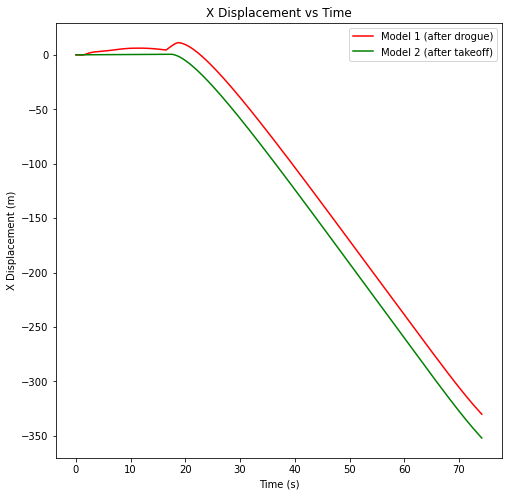

In [18]:
fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
ax.plot(t1, x1, color='red', label='Model 1 (after drogue)')
ax.plot(t, x, color='green', label='Model 2 (after takeoff)')
ax.set_title("X Displacement vs Time")  # 'interpreter','latex', 'FontSize', 16
ax.set_xlabel("Time (s)")  # 'interpreter','latex', 'FontSize', 16
ax.set_ylabel("X Displacement (m)")  # 'interpreter','latex', 'FontSize', 16
ax.legend()
plt.show()